# Load Data

In [13]:
import torch
from auto_cast.data.dataset import BOUTDataset
from auto_cast.data.datamodule import SpatioTemporalDataModule
from torch.utils.data import DataLoader



In [14]:
from auto_cast.data.dataset import BOUTDataset
from auto_cast.data.datamodule import SpatioTemporalDataModule

# Load with datamodule
datamodule = SpatioTemporalDataModule(
    data_path="data/bout_split",
    dataset_cls=BOUTDataset,
    n_steps_input=5,   # Use 5 input frames
    n_steps_output=40,  # Predict 5 future frames
    stride=1,
    batch_size=4,
    dtype=torch.float32,  # Convert from float64 to float32
    ftype="torch",
    verbose=True,
)




Loaded data shape: torch.Size([78, 51, 1, 256, 256])
Created 546 subtrajectory samples
Each input sample shape: torch.Size([5, 1, 256, 256])
Each output sample shape: torch.Size([40, 1, 256, 256])
Data type: torch.float32
Loaded data shape: torch.Size([16, 51, 1, 256, 256])
Created 112 subtrajectory samples
Each input sample shape: torch.Size([5, 1, 256, 256])
Each output sample shape: torch.Size([40, 1, 256, 256])
Data type: torch.float32
Loaded data shape: torch.Size([18, 51, 1, 256, 256])
Created 126 subtrajectory samples
Each input sample shape: torch.Size([5, 1, 256, 256])
Each output sample shape: torch.Size([40, 1, 256, 256])
Data type: torch.float32
Loaded data shape: torch.Size([78, 51, 1, 256, 256])
Created 78 subtrajectory samples
Each input sample shape: torch.Size([5, 1, 256, 256])
Each output sample shape: torch.Size([46, 1, 256, 256])
Data type: torch.float32
Loaded data shape: torch.Size([18, 51, 1, 256, 256])
Created 18 subtrajectory samples
Each input sample shape: to

In [15]:
# Get a batch
train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))

In [16]:
batch.input_fields.shape, batch.output_fields.shape, batch.constant_scalars.shape

(torch.Size([4, 5, 1, 256, 256]),
 torch.Size([4, 40, 1, 256, 256]),
 torch.Size([4, 6]))

In [ ]:
import torch
import torch.nn as nn
from azula.noise import CosineSchedule
from auto_cast.data.dataset import BOUTDataset
from auto_cast.data.datamodule import SpatioTemporalDataModule
from auto_cast.types import EncodedBatch


# ============================================================================
# 2. Load Data
# ============================================================================

print("="*70)
print("Loading BOUT Dataset")
print("="*70)

datamodule = SpatioTemporalDataModule(
    data_path="data/bout_split",
    dataset_cls=BOUTDataset,
    n_steps_input=5,
    n_steps_output=5,
    stride=1,
    batch_size=4,
    dtype=torch.float32,
    ftype="torch",
    verbose=True,
)

train_loader = datamodule.train_dataloader()
batch = next(iter(train_loader))

print(f"\n📊 Batch shapes (after collate_batches):")
print(f"   Input:  {batch.input_fields.shape}")   # Should be [4, 5, 1, 256, 256]
print(f"   Output: {batch.output_fields.shape}")  # Should be [4, 5, 1, 256, 256]
print(f"   Const scalars: {batch.constant_scalars.shape if batch.constant_scalars is not None else None}")



Loading BOUT Dataset
Loaded data shape: torch.Size([78, 51, 1, 256, 256])
Created 3276 subtrajectory samples
Each input sample shape: torch.Size([5, 1, 256, 256])
Each output sample shape: torch.Size([5, 1, 256, 256])
Data type: torch.float32
Loaded data shape: torch.Size([16, 51, 1, 256, 256])
Created 672 subtrajectory samples
Each input sample shape: torch.Size([5, 1, 256, 256])
Each output sample shape: torch.Size([5, 1, 256, 256])
Data type: torch.float32
Loaded data shape: torch.Size([18, 51, 1, 256, 256])
Created 756 subtrajectory samples
Each input sample shape: torch.Size([5, 1, 256, 256])
Each output sample shape: torch.Size([5, 1, 256, 256])
Data type: torch.float32
Loaded data shape: torch.Size([78, 51, 1, 256, 256])
Created 78 subtrajectory samples
Each input sample shape: torch.Size([5, 1, 256, 256])
Each output sample shape: torch.Size([46, 1, 256, 256])
Data type: torch.float32
Loaded data shape: torch.Size([18, 51, 1, 256, 256])
Created 18 subtrajectory samples
Each inp

In [25]:
from azula.nn.unet import UNet
from azula.nn.embedding import SineEncoding

class TemporalUNetBackbone(nn.Module):
    """Azula UNet with proper time embedding."""
    
    def __init__(
        self,
        in_channels: int = 1,
        out_channels: int = 1,
        mod_features: int = 256,
        hid_channels: tuple = (32, 64, 128),
        hid_blocks: tuple = (2, 2, 2),
        spatial: int = 2,
        periodic: bool = False,
    ):
        super().__init__()
        
        # Time embedding
        self.time_embedding = nn.Sequential(
            SineEncoding(mod_features),
            nn.Linear(mod_features, mod_features),
            nn.SiLU(),
            nn.Linear(mod_features, mod_features),
        )
        
        self.unet = UNet(
            in_channels=in_channels,
            out_channels=out_channels,
            cond_channels=0,
            mod_features=mod_features,
            hid_channels=hid_channels,
            hid_blocks=hid_blocks,
            kernel_size=3,
            stride=2,
            spatial=spatial,
            periodic=periodic,
        )
    
    def forward(self, x: torch.Tensor, t: torch.Tensor) -> torch.Tensor:
        B, T, C, H, W = x.shape
        
        # Embed time
        t_emb = self.time_embedding(t)  # (B, mod_features)
        
        # Flatten temporal
        x_flat = x.reshape(B * T, C, H, W)
        t_emb_expanded = t_emb.repeat_interleave(T, dim=0)
        
        # Process
        out_flat = self.unet(x_flat, mod=t_emb_expanded)
        
        # Reshape
        return out_flat.reshape(B, T, C, H, W)




# ============================================================================
# 3. Create DiffusionProcessor
# ============================================================================

In [26]:
from auto_cast.processors.diffusion import DiffusionProcessor

B, T, C, H, W = batch.output_fields.shape

# Create backbone
backbone = TemporalUNetBackbone(
    in_channels=C,
    out_channels=C,
    mod_features=256,
    hid_channels=(16, 32, 64),  # Small for testing
    hid_blocks=(2, 2, 2),
    spatial=2,
    periodic=False,
)
# Create schedule
schedule = CosineSchedule(alpha_min=0.001, sigma_min=0.001)

# Create processor
processor = DiffusionProcessor(
    backbone=backbone,
    schedule=schedule,
    denoiser_type='karras',
    learning_rate=1e-4,
)


✅ DiffusionProcessor created
   Backbone params: 1,712,513

Testing Forward Pass

🔥 Testing training_step...
   ✅ Loss: 0.8886

🔮 Testing map (prediction)...
   ✅ Output shape: torch.Size([4, 5, 1, 256, 256])
   Expected shape: torch.Size([4, 5, 1, 256, 256])
   Step 0: loss = 0.8356
   Step 1: loss = 0.8004
   Step 2: loss = 0.7567
   Step 3: loss = 1.0787
   Step 4: loss = 0.8112
   Step 5: loss = 0.8472
   Step 6: loss = 0.7426
   Step 7: loss = 0.6415
   Step 8: loss = 0.6018
   Step 9: loss = 0.5975
   Step 10: loss = 0.5739
   Step 11: loss = 0.8073
   Step 12: loss = 0.8148
   Step 13: loss = 0.7625
   Step 14: loss = 0.8181
   Step 15: loss = 0.9142
   Step 16: loss = 0.5297
   Step 17: loss = 0.3344
   Step 18: loss = 0.3671
   Step 19: loss = 0.5850
   Step 20: loss = 0.5085
   Step 21: loss = 0.3180
   Step 22: loss = 0.7371
   Step 23: loss = 0.5721
   Step 24: loss = 0.4428
   Step 25: loss = 0.2426
   Step 26: loss = 0.4212
   Step 27: loss = 0.9607
   Step 28: loss = 0.7

# ============================================================================
# 4. Test Forward Pass
# ============================================================================

In [27]:
# Create encoded batch
encoded_batch = EncodedBatch(
    encoded_inputs=batch.input_fields,
    encoded_output_fields=batch.output_fields,
    encoded_info={}
)

# Test training step
loss = processor.training_step(encoded_batch, 0)
print(f"Loss: {loss.item():.4f}")

# Test map (prediction)
output = processor.map(batch.input_fields)
print(f"Output shape: {output.shape}")
print(f"Expected shape: {batch.input_fields.shape}")
assert output.shape == batch.input_fields.shape, "Shape mismatch!"



Loss: 0.4383
Output shape: torch.Size([4, 5, 1, 256, 256])
Expected shape: torch.Size([4, 5, 1, 256, 256])



# ============================================================================
# 5. Quick Training Loop
# ============================================================================



In [ ]:

processor.train()
optimizer = torch.optim.Adam(processor.parameters(), lr=1e-4)

for step in range(100):
    batch = next(iter(train_loader))
    encoded_batch = EncodedBatch(
        encoded_inputs=batch.input_fields,
        encoded_output_fields=batch.output_fields,
        encoded_info={}
    )
    
    optimizer.zero_grad()
    loss = processor.training_step(encoded_batch, step)
    loss.backward()
    optimizer.step()
    
    print(f"   Step {step}: loss = {loss.item():.4f}")


# ============================================================================
# 6. Visualize Results
# ============================================================================

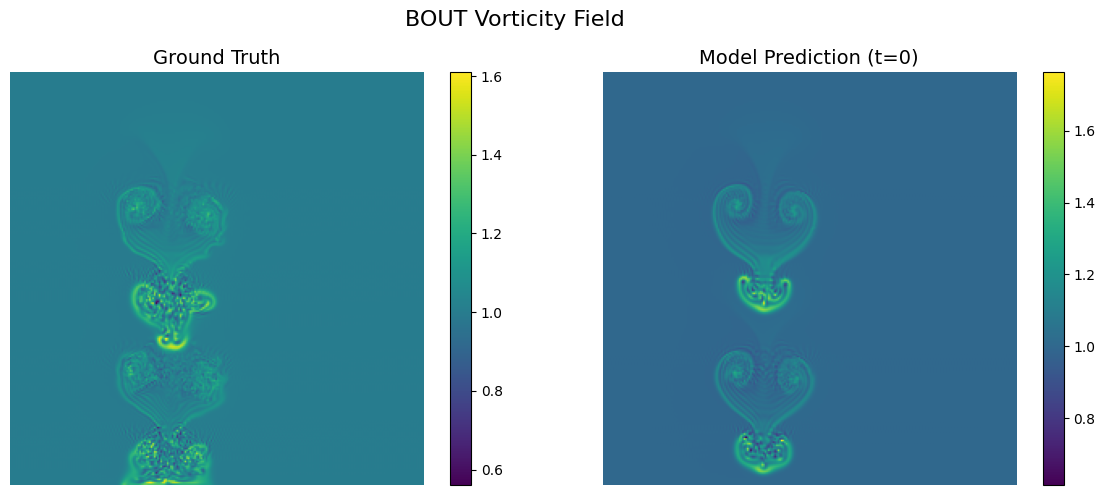

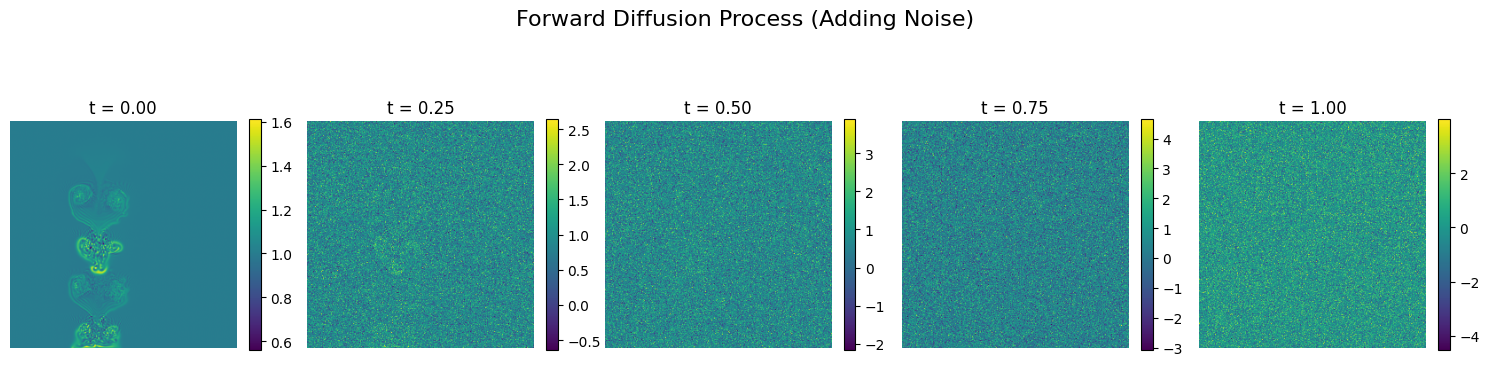

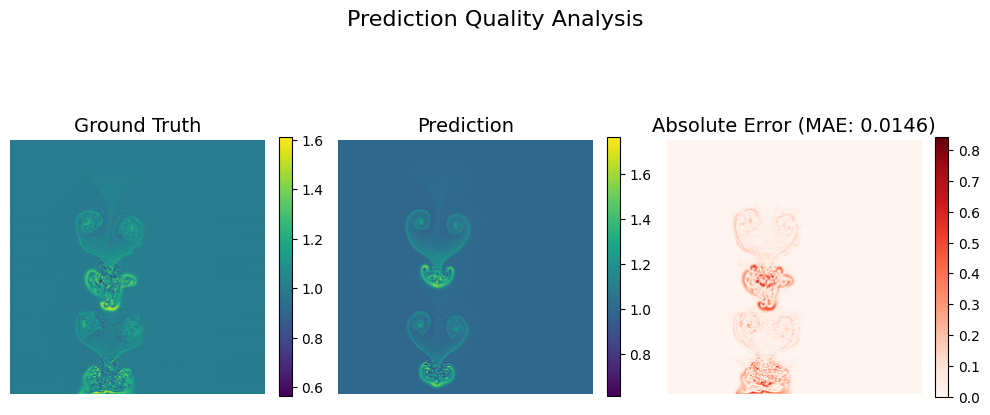


Statistics
MSE:  0.002115
MAE:  0.014304
GT Range:   [0.561, 1.757]
Pred Range: [0.501, 1.764]


In [28]:
import matplotlib.pyplot as plt
import numpy as np


processor.eval()

# Get a test batch
test_batch = next(iter(train_loader))
test_encoded = EncodedBatch(
    encoded_inputs=test_batch.input_fields,
    encoded_output_fields=test_batch.output_fields,
    encoded_info={}
)

# Get ground truth and prediction
with torch.no_grad():
    # Ground truth
    x_gt = test_batch.output_fields  # (B, T, C, H, W)
    
    # Prediction (denoised at t=0)
    x_pred = processor.map(test_batch.input_fields)
    
    # Noisy samples at different noise levels
    B = x_gt.shape[0]
    t_levels = [0.0, 0.25, 0.5, 0.75, 1.0]
    noisy_samples = []
    
    for t_val in t_levels:
        t = torch.full((B,), t_val, device=x_gt.device)
        alpha_t, sigma_t = processor.schedule(t)
        alpha_t = alpha_t.view(-1, 1, 1, 1, 1)
        sigma_t = sigma_t.view(-1, 1, 1, 1, 1)
        noise = torch.randn_like(x_gt)
        x_noisy = alpha_t * x_gt + sigma_t * noise
        noisy_samples.append(x_noisy)

# Convert to numpy for plotting
x_gt_np = x_gt[0, 0, 0].cpu().numpy()       # First batch, first time, first channel
x_pred_np = x_pred[0, 0, 0].cpu().numpy()
noisy_np = [x[0, 0, 0].cpu().numpy() for x in noisy_samples]

# ============================================================================
# Plot 1: Ground Truth vs Prediction
# ============================================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Ground truth
im0 = axes[0].imshow(x_gt_np, cmap='viridis')
axes[0].set_title('Ground Truth', fontsize=14)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Prediction
im1 = axes[1].imshow(x_pred_np, cmap='viridis')
axes[1].set_title('Model Prediction (t=0)', fontsize=14)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

plt.suptitle('BOUT Vorticity Field', fontsize=16, y=0.98)
plt.tight_layout()

plt.show()

# ============================================================================
# Plot 2: Noise Schedule Visualization
# ============================================================================

fig, axes = plt.subplots(1, len(t_levels), figsize=(15, 4))

for idx, (t_val, noisy) in enumerate(zip(t_levels, noisy_np)):
    im = axes[idx].imshow(noisy, cmap='viridis')
    axes[idx].set_title(f't = {t_val:.2f}', fontsize=12)
    axes[idx].axis('off')
    plt.colorbar(im, ax=axes[idx], fraction=0.046)

plt.suptitle('Forward Diffusion Process (Adding Noise)', fontsize=16, y=1.02)
plt.tight_layout()

plt.show()

# ============================================================================
# Plot 3: Error Map
# ============================================================================

error = np.abs(x_gt_np - x_pred_np)

fig, axes = plt.subplots(1, 3, figsize=(10, 5))

# Ground truth
im0 = axes[0].imshow(x_gt_np, cmap='viridis')
axes[0].set_title('Ground Truth', fontsize=14)
axes[0].axis('off')
plt.colorbar(im0, ax=axes[0], fraction=0.046)

# Prediction
im1 = axes[1].imshow(x_pred_np, cmap='viridis')
axes[1].set_title('Prediction', fontsize=14)
axes[1].axis('off')
plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Error
im2 = axes[2].imshow(error, cmap='Reds')
axes[2].set_title(f'Absolute Error (MAE: {error.mean():.4f})', fontsize=14)
axes[2].axis('off')
plt.colorbar(im2, ax=axes[2], fraction=0.046)

plt.suptitle('Prediction Quality Analysis', fontsize=16, y=0.98)
plt.tight_layout()

plt.show()


# ============================================================================
# Print Statistics
# ============================================================================

print("\n" + "="*70)
print("Statistics")
print("="*70)

with torch.no_grad():
    mse = ((x_gt - x_pred) ** 2).mean().item()
    mae = (x_gt - x_pred).abs().mean().item()
    
    print(f"MSE:  {mse:.6f}")
    print(f"MAE:  {mae:.6f}")
    print(f"GT Range:   [{x_gt.min().item():.3f}, {x_gt.max().item():.3f}]")
    print(f"Pred Range: [{x_pred.min().item():.3f}, {x_pred.max().item():.3f}]")


✅ Saved: diffusion_temporal.png


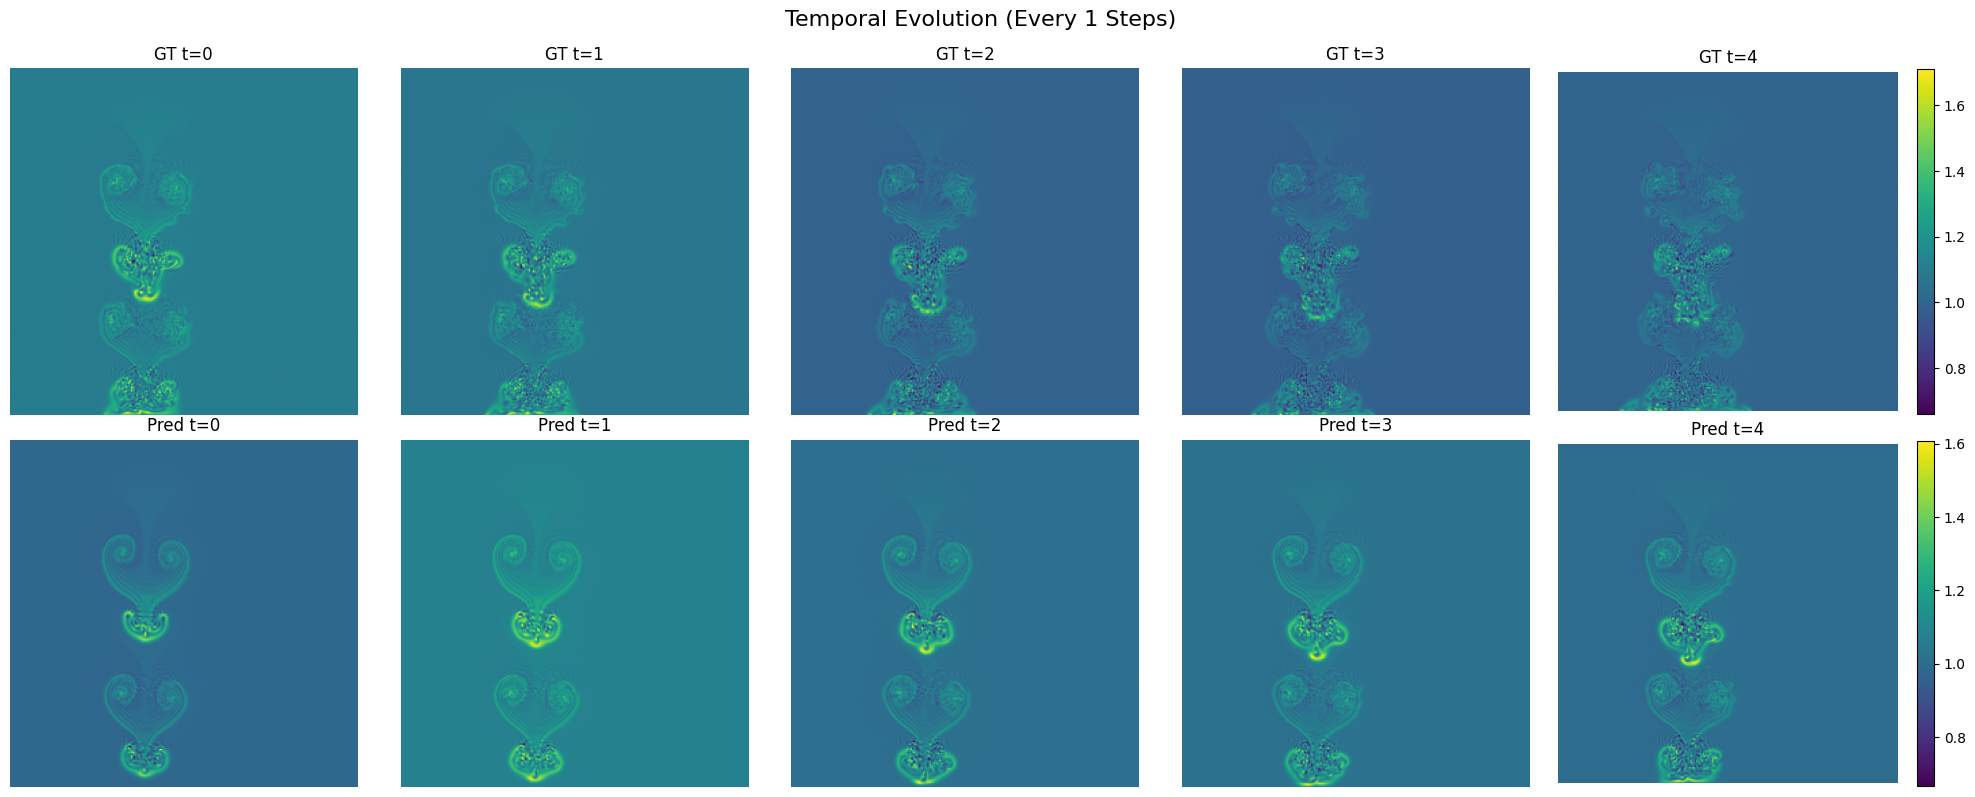

In [29]:
# ============================================================================
# Plot 4: Time Series Comparison (Every 10 Steps)
# ============================================================================

# Show every 10th time step
T = x_gt.shape[1]  # Total number of time steps
step_size = 1
time_indices = list(range(0, T, step_size))
if time_indices[-1] != T - 1:  # Always include the last frame
    time_indices.append(T - 1)

n_frames = len(time_indices)
fig, axes = plt.subplots(2, n_frames, figsize=(4*n_frames, 8))

# Handle case where we only have 1 frame
if n_frames == 1:
    axes = axes.reshape(2, 1)

for plot_idx, t_idx in enumerate(time_indices):
    # Ground truth
    gt_frame = x_gt[0, t_idx, 0].cpu().numpy()
    im0 = axes[0, plot_idx].imshow(gt_frame, cmap='viridis')
    axes[0, plot_idx].set_title(f'GT t={t_idx}', fontsize=12)
    axes[0, plot_idx].axis('off')
    if plot_idx == n_frames - 1:  # Add colorbar to last plot
        plt.colorbar(im0, ax=axes[0, plot_idx], fraction=0.046)
    
    # Prediction
    pred_frame = x_pred[0, t_idx, 0].cpu().numpy()
    im1 = axes[1, plot_idx].imshow(pred_frame, cmap='viridis')
    axes[1, plot_idx].set_title(f'Pred t={t_idx}', fontsize=12)
    axes[1, plot_idx].axis('off')
    if plot_idx == n_frames - 1:  # Add colorbar to last plot
        plt.colorbar(im1, ax=axes[1, plot_idx], fraction=0.046)

axes[0, 0].set_ylabel('Ground Truth', fontsize=14, rotation=0, ha='right', va='center')
axes[1, 0].set_ylabel('Prediction', fontsize=14, rotation=0, ha='right', va='center')

plt.suptitle(f'Temporal Evolution (Every {step_size} Steps)', fontsize=16, y=0.99)
plt.tight_layout()
plt.savefig('diffusion_temporal.png', dpi=150, bbox_inches='tight')
print("✅ Saved: diffusion_temporal.png")
plt.show()

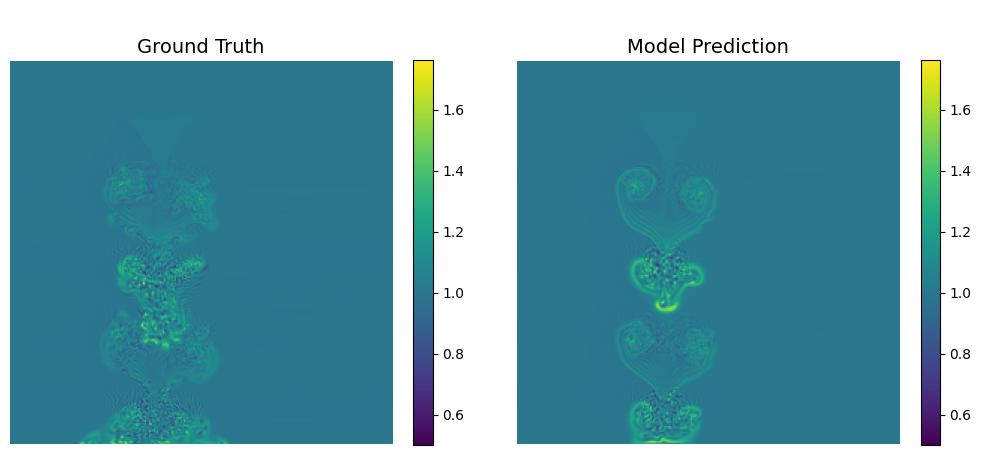

In [30]:
from matplotlib.animation import FuncAnimation, FFMpegWriter
from IPython.display import Video

# ============================================================================
# Plot 5: Animated Video - Ground Truth vs Prediction
# ============================================================================

# Get data for video
x_gt_video = x_gt[0, :, 0].cpu().numpy()    # (T, H, W)
x_pred_video = x_pred[0, :, 0].cpu().numpy()  # (T, H, W)
T = x_gt_video.shape[0]

# Determine common color scale for consistency
vmin = min(x_gt_video.min(), x_pred_video.min())
vmax = max(x_gt_video.max(), x_pred_video.max())

# Create figure for animation
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Initial frames
im0 = axes[0].imshow(x_gt_video[0], cmap='viridis', vmin=vmin, vmax=vmax, animated=True)
axes[0].set_title('Ground Truth', fontsize=14)
axes[0].axis('off')
cbar0 = plt.colorbar(im0, ax=axes[0], fraction=0.046)

im1 = axes[1].imshow(x_pred_video[0], cmap='viridis', vmin=vmin, vmax=vmax, animated=True)
axes[1].set_title('Model Prediction', fontsize=14)
axes[1].axis('off')
cbar1 = plt.colorbar(im1, ax=axes[1], fraction=0.046)

# Time text
time_text = fig.suptitle(f'Time Step: 0 / {T-1}', fontsize=16, y=0.98)

def update(frame):
    """Update function for animation."""
    im0.set_array(x_gt_video[frame])
    im1.set_array(x_pred_video[frame])
    time_text.set_text(f'Time Step: {frame} / {T-1}')
    return [im0, im1, time_text]

# Create animation
anim = FuncAnimation(fig, update, frames=T, interval=100, blit=True, repeat=True)
anim.save('diffusion_video.gif', writer='pillow', fps=10)
